<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-donut-chart" data-toc-modified-id="Create-donut-chart-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create donut chart</a></span></li><li><span><a href="#Bar-chart" data-toc-modified-id="Bar-chart-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bar chart</a></span></li><li><span><a href="#Plot-accumulation-of-data" data-toc-modified-id="Plot-accumulation-of-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot accumulation of data</a></span></li><li><span><a href="#Other-grant-stuff" data-toc-modified-id="Other-grant-stuff-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Other grant stuff</a></span></li></ul></div>

In [1]:
import sys

sys.path.append('../modulome/')

In [2]:
from modulome.config import *
from modulome.util import get_latest_sra
from modulome import taxon
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from Bio import Entrez
Entrez.email = 'avsastry@eng.ucsd.edu' # Tell NCBI who you are

# Create donut chart

In [4]:
latest_pull = get_latest_sra('../data/sra_dumps/')
print('Latest pull: {}'.format(latest_pull))

Latest pull: 2020-08-20


In [5]:
metadata_file = '../data/sra_dumps/sra_metadata_{}.csv'.format(latest_pull)
DF_metadata = pd.read_csv(metadata_file,low_memory=False,sep='\t')

In [6]:
sns.set_style('ticks')
plt.style.use('custom')

In [22]:
DF_metadata[['acnes' in x for x in DF_metadata.species]]

,Experiment,ReleaseDate,TaxID,ScientificName,species_tax_id,class_tax_id,strain_tax_id,species,LibraryLayout,Platform,...,Sample,BioSample,Submission,LibraryStrategy,LibrarySelection,LibrarySource,Body_Site,CenterName,InsertSize,InsertDev
16367,SRX276771,2015-07-22 17:04:02,267747,Cutibacterium acnes KPA171202,1747,1760,267747,Cutibacterium acnes,SINGLE,ILLUMINA,...,SRS419951,SAMN02141765,SRA075709,RNA-Seq,cDNA,TRANSCRIPTOMIC,NaN,GEO,0,0.0
16368,SRX276772,2015-07-22 17:04:02,267747,Cutibacterium acnes KPA171202,1747,1760,267747,Cutibacterium acnes,SINGLE,ILLUMINA,...,SRS419948,SAMN02141766,SRA075709,RNA-Seq,cDNA,TRANSCRIPTOMIC,NaN,GEO,0,0.0
16369,SRX276773,2015-07-22 17:04:02,267747,Cutibacterium acnes KPA171202,1747,1760,267747,Cutibacterium acnes,SINGLE,ILLUMINA,...,SRS419949,SAMN02141767,SRA075709,RNA-Seq,cDNA,TRANSCRIPTOMIC,NaN,GEO,0,0.0
16370,SRX276774,2015-07-22 17:04:02,267747,Cutibacterium acnes KPA171202,1747,1760,267747,Cutibacterium acnes,SINGLE,ILLUMINA,...,SRS419950,SAMN02141768,SRA075709,RNA-Seq,cDNA,TRANSCRIPTOMIC,NaN,GEO,0,0.0
16528,SRX278002,2013-05-16 15:26:42,267747,Cutibacterium acnes KPA171202,1747,1760,267747,Cutibacterium acnes,SINGLE,ILLUMINA,...,SRS420924,SAMN02144185,SRA076496,RNA-Seq,cDNA,TRANSCRIPTOMIC,NaN,GEO,0,0.0
16529,SRX278003,2013-05-16 15:26:42,267747,Cutibacterium acnes KPA171202,1747,1760,267747,Cutibacterium acnes,SINGLE,ILLUMINA,...,SRS420925,SAMN02144186,SRA076496,RNA-Seq,cDNA,TRANSCRIPTOMIC,NaN,GEO,0,0.0


In [15]:
def simplify_counts(df,threshold=200):
    keep = df[df > threshold]
    other = df[df <= threshold]
    keep['Other'] = other.sum()
    
    # Move "no strain/class/species" to end
    if -1 in keep.index:
        final_df = keep.drop(-1)
        return final_df.append(keep.loc[[-1]])
    
    return keep

In [16]:
## Plot class

# Get number of experiments in each class
class_count = DF_metadata.class_tax_id.value_counts()
class_count = simplify_counts(class_count,300) # Group small counts in "Other" category

# Get information for pie chart
class_sizes = class_count.values
class_labels = taxon.get_tax_name_counts(class_count,reformat=False)

# Get colors for pie chart
num_classes = len(class_count)-1
class_colors = [list(x) for x in sns.color_palette('dark',n_colors=num_classes)]
class_colors.append([.9,.9,.9]) # "Other" class is light gray

In [17]:
## Plot species

# Get counts of species in each class
species_groups = []
for tax in class_count.index[:-1]:
    species = DF_metadata[DF_metadata.class_tax_id == tax].species_tax_id.value_counts()
    species_groups.append(simplify_counts(species,200)) # Group small counts in "Other" category
    
# Get information for pie chart
species_count = pd.concat(species_groups).append(class_count.iloc[[-1]])
species_sizes = species_count.values
species_labels = taxon.get_tax_name_counts(species_count)

# Get colors for pie chart
species_per_class = [len(group)-1 for group in species_groups]

species_colors = []
for class_index,num_colors in enumerate(species_per_class):
    # Start the palette on the same color as the class
    species_palette = [list(x) for x in sns.color_palette('colorblind',n_colors=class_index+num_colors)]
    species_colors += species_palette[class_index:]
    species_colors.append([.9,.9,.9]) # "Other" species are light gray
    
species_colors.append([.9,.9,.9])# Account for "Other" class

In [18]:
strain_groups = []

# Get counts of strain in each species
for tax,count in species_count.items():
    # Add "Other" counts
    if tax == 'Other':
        strain_groups.append(pd.Series({'other_species':count}))
    else:
        strains = DF_metadata[DF_metadata.species_tax_id == tax].strain_tax_id.value_counts()
        strain_groups.append(simplify_counts(strains,100))

# Get information for pie chart
strain_count = pd.concat(strain_groups)
strain_sizes = strain_count.values
strain_labels = taxon.get_tax_name_counts(strain_count,threshold=100)

# Get strain colors
strain_colors = []
for color,group in zip(species_colors,strain_groups):
    base_color = [x + (1-x)*.3 for x in color]
    strain_palette = sns.light_palette(base_color, input="rgb",n_colors=len(group),reverse=True)
    counter = 0
    for strain_id in group.index:
        if strain_id == 'Other':
            strain_colors.append([1,1,1]) # Low data strains are white
        elif strain_id == 'other_species':
            strain_colors.append([.9,.9,.9]) # "Other" species is light gray
        else:
            strain_colors.append(strain_palette[counter])
            counter += 1

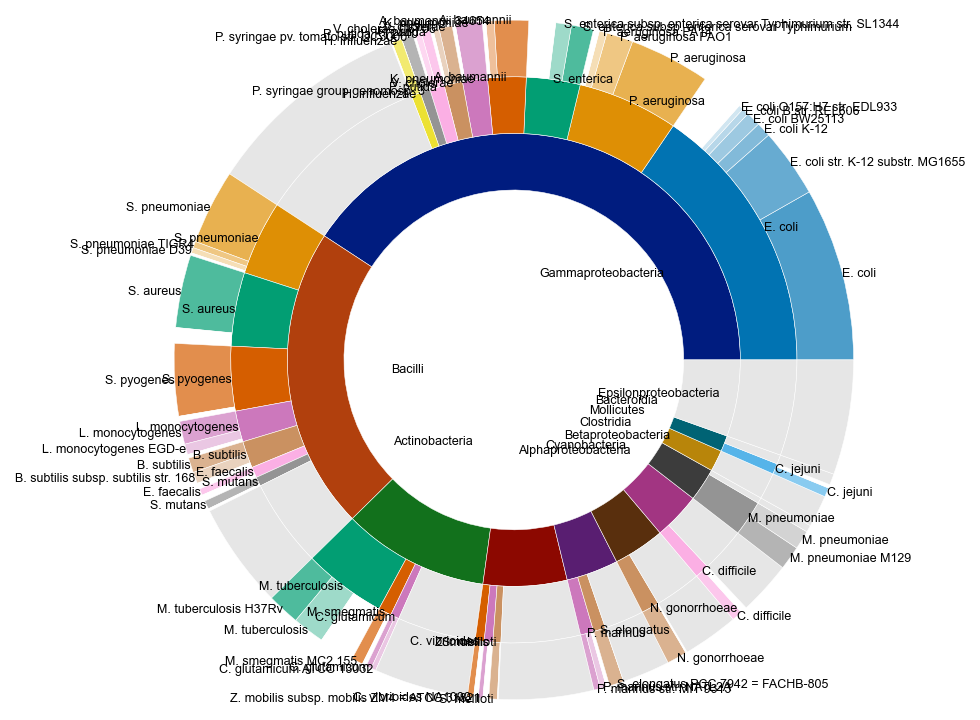

In [19]:
# Plot pie chart
plt.pie(class_sizes,labels=class_labels,colors=class_colors,radius=2,
        wedgeprops=dict(width=.5,linewidth=.25,edgecolor='white'),
        labeldistance=0.4);
    
plt.pie(species_sizes,labels=species_labels,colors=species_colors,radius=2.5,
        wedgeprops=dict(width=.5,linewidth=.25,edgecolor='white'),labeldistance=1);

plt.pie(strain_sizes,labels=strain_labels,colors=strain_colors,radius=3,
        wedgeprops=dict(width=.5,linewidth=.25,edgecolor='white'),labeldistance=1);
plt.savefig('figures/phylogeny.pdf')

# Bar chart

In [20]:
u19_species = ['Acinetobacter baumannii','Clostridioides difficile',
               'Neisseria gonorrhoeae','Campylobacter jejuni',
               'Pseudomonas aeruginosa','Salmonella enterica',
               'Staphylococcus aureus','Streptococcus pneumoniae',
               'Streptococcus pyogenes','Escherichia coli']

In [21]:
u19_metadata = DF_metadata[DF_metadata.species.isin(u19_species)]

['E. coli', 'E. coli str. K-12 substr. MG1655', 'E. coli K-12', 'E. coli BW25113', 'E. coli B str. REL606', 'E. coli O157:H7 str. EDL933', '']
['P. aeruginosa', 'P. aeruginosa PAO1', 'P. aeruginosa PA14', '']
['S. pneumoniae', 'S. pneumoniae TIGR4', 'S. pneumoniae D39', '']
['S. aureus', '']
['S. pyogenes', '']
['S. enterica subsp. enterica serovar Typhimurium', 'S. enterica subsp. enterica serovar Typhimurium str. SL1344', '']
['A. baumannii', 'A. baumannii 34654', '']
['N. gonorrhoeae', '']
['C. difficile', '']
['C. jejuni', '']


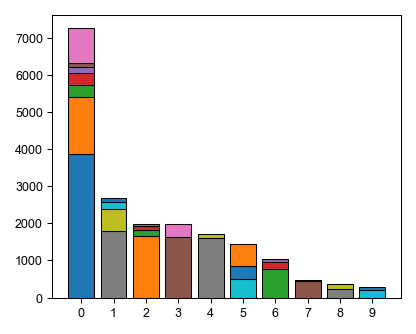

In [22]:
final_df = []
i = 0
for name,group in sorted(u19_metadata.groupby('species_tax_id'),key=lambda x:len(x[1]),reverse=True):
    species_count = simplify_counts(group.strain_tax_id.value_counts(),100)
    bottoms = species_count.cumsum()
    species_label = taxon.get_tax_name_counts(species_count)
    print(species_label)
    for j,(k,val) in enumerate(species_count.iteritems()):
        if j == 0:
            plt.bar(i,val,bottom=0,label=k)
        else:
            plt.bar(i,val,bottom=bottoms.iloc[j-1],label=k)
    i+=1
plt.xticks(range(10))
plt.savefig('/home/anand/Dropbox/tmp/U19_bars.pdf')

In [23]:
## Plot species

# Get counts of species in each class
species_groups = []
for tax in u19_species:
    species = DF_metadata[DF_metadata.class_tax_id == tax].species_tax_id.value_counts()
    species_groups.append(simplify_counts(species,200)) # Group small counts in "Other" category
    
# Get information for pie chart
species_count = pd.concat(species_groups).append(class_count.iloc[[-1]])
species_sizes = species_count.values
species_labels = taxon.get_tax_name_counts(species_count)

# Get colors for pie chart
species_per_class = [len(group)-1 for group in species_groups]

species_colors = []
for class_index,num_colors in enumerate(species_per_class):
    # Start the palette on the same color as the class
    species_palette = [list(x) for x in sns.color_palette('colorblind',n_colors=class_index+num_colors)]
    species_colors += species_palette[class_index:]
    species_colors.append([.9,.9,.9]) # "Other" species are light gray
    
species_colors.append([.9,.9,.9])# Account for "Other" class

# Simplify for U19

species_labels = list(np.array(species_labels)[species_index])



/home/anand/miniconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


NameError: name 'np' is not defined

In [ ]:
import numpy as np

In [ ]:
strain_groups = []

# Get counts of strain in each species
for tax,count in species_count.items():
    # Add "Other" counts
    if tax == 'Other':
        strain_groups.append(pd.Series({'other_species':count}))
    else:
        strains = DF_metadata[DF_metadata.species_tax_id == tax].strain_tax_id.value_counts()
        strain_groups.append(simplify_counts(strains,100))

# Get information for pie chart
strain_count = pd.concat(strain_groups)
strain_sizes = strain_count.values
strain_labels = taxon.get_tax_name_counts(strain_count,threshold=100)

# Get strain colors
strain_colors = []
for color,group in zip(species_colors,strain_groups):
    base_color = [x + (1-x)*.3 for x in color]
    strain_palette = sns.light_palette(base_color, input="rgb",n_colors=len(group),reverse=True)
    counter = 0
    for strain_id in group.index:
        if strain_id == 'Other':
            strain_colors.append([1,1,1]) # Low data strains are white
        elif strain_id == 'other_species':
            strain_colors.append([.9,.9,.9]) # "Other" species is light gray
        else:
            strain_colors.append(strain_palette[counter])
            counter += 1

# Plot accumulation of data

In [114]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata.ReleaseDate).dt.date

In [115]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata.ReleaseDate).dt.year

In [116]:
u19_subspecies = ['Acinetobacter baumannii','Salmonella enterica',
               'Staphylococcus aureus','Escherichia coli']

In [117]:
u19_species = ['Acinetobacter baumannii','Clostridioides difficile',
               'Neisseria gonorrhoeae','Campylobacter jejuni',
               'Pseudomonas aeruginosa','Salmonella enterica',
               'Staphylococcus aureus','Streptococcus pneumoniae',
               'Streptococcus pyogenes','Escherichia coli']

In [118]:
u19_metadata = DF_metadata[DF_metadata.species.isin(u19_species)]

In [119]:
u19_metadata['species'] = [x.split(' ')[0][0]+'. '+x.split(' ')[1] for x in u19_metadata.species]

/home/anand/bin/miniconda3/envs/main3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [120]:
cdict = dict(zip(['E. coli','C. difficile','A. baumannii','P. aeruginosa','S. aureus','N. gonorrhoeae',
              'S. enterica','S. pneumoniae','S. pyogenes','C. jejuni'],sns.palettes.color_palette('tab10')))

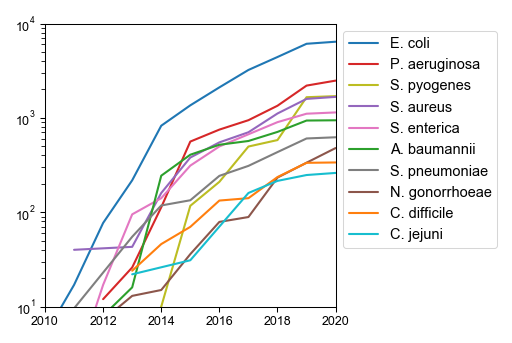

In [98]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig,ax = plt.subplots(figsize=(2.5,2.5))

for name,group in sorted(u19_metadata.groupby('species'),key=lambda x: len(x[1]),reverse=True):
    df = group['ReleaseDate'].value_counts().sort_index().cumsum()
    
    ax.plot(df,label=name,color = cdict[name])
plt.legend(bbox_to_anchor=(1,1))
plt.yscale('log')
plt.ylim([10,1e4])
plt.xlim([2010,2020])
plt.savefig('figures/data_accumulation.pdf')

In [138]:
df = pd.read_excel('/home/anand/Downloads/genomes_FINAL.xlsx')


In [139]:
df

,ecoli,cdiff,abaumannii,paeruginosa,saureus,ngonorrhoeae,senterica,spneumoniae,spyogenes,cjejuni
2000,1,NaN,NaN,1,NaN,2,NaN,NaN,NaN,1
2001,2,NaN,NaN,1,2.0,2,2.0,NaN,1.0,1
2002,3,NaN,NaN,1,3.0,2,2.0,NaN,3.0,1
2003,3,NaN,NaN,3,4.0,2,3.0,NaN,4.0,2
2004,3,NaN,1.0,3,6.0,2,4.0,NaN,6.0,2
2005,9,NaN,1.0,7,11.0,3,5.0,NaN,8.0,3
2006,13,2.0,1.0,12,13.0,3,5.0,NaN,12.0,9
2007,26,7.0,2.0,16,19.0,5,18.0,NaN,13.0,13
2008,43,10.0,13.0,22,22.0,19,37.0,NaN,14.0,15
2009,62,12.0,19.0,28,72.0,31,40.0,NaN,14.0,15


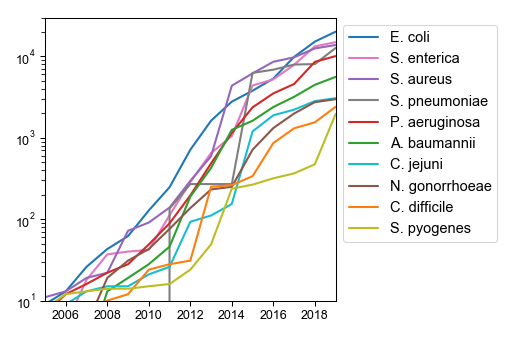

In [136]:
df = pd.read_excel('/home/anand/Downloads/genomes_FINAL.xlsx')
df.columns = ['E. coli','C. difficile','A. baumannii','P. aeruginosa','S. aureus','N. gonorrhoeae',
              'S. enterica','S. pneumoniae','S. pyogenes','C. jejuni']
df = df.fillna(0)

fig,ax = plt.subplots(figsize=(2.5,2.5))
for col in df.loc[2019].sort_values(ascending=False).index:
    ax.plot(df[col],label=col,color = cdict[col])

plt.legend(bbox_to_anchor=(1,1))
plt.yscale('log')
plt.ylim([10,3e4])
plt.xlim([2005,2019])
plt.savefig('figures/genome_accumulation.pdf')

# Other grant stuff

In [113]:
len(DF_metadata[DF_metadata.species =='Staphylococcus aureus'])

1669

In [41]:
u19_species = ['Acinetobacter baumannii','Clostridioides difficile',
               'Neisseria gonorrhoeae','Campylobacter jejuni',
               'Pseudomonas aeruginosa','Salmonella enterica',
               'Staphylococcus aureus','Streptococcus pneumoniae',
               'Streptococcus pyogenes','Escherichia coli']

In [108]:
len(DF_metadata.ScientificName[DF_metadata.ScientificName.isin(['Salmonella enterica subsp. enterica serovar Typhi','Salmonella enterica subsp. enterica serovar Typhi str. Ty2'])])

37

In [142]:
qc = pd.read_csv('/home/anand/Dropbox/Projects/u19_projects/prelim_salmonella/qc_data_round_2.csv',index_col=0)

In [147]:
exps = DF_metadata[['Enteritidis' in x for x in DF_metadata.ScientificName]]['Experiment']

In [148]:
qc.loc[exps.values]

/home/anand/bin/miniconda3/envs/main3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,mRNA-sense,mRNA-antisense,rRNA-sense,rRNA-antisense,tRNA-sense,tRNA-antisense,ncRNA-sense,ncRNA-antisense,unannotated,total-reads,...,pe_antisense,failed,se_sense,se_antisense,r_processed,r_with_adapters,bp_processed,quality_trimmed,bp_written,percent_trimmed
ERX1776993,2539.0,1255.0,99970.0,19747.0,0.0,0.0,0.0,0.0,18.0,8895266.0,...,1.0000,0.0000,NaN,NaN,9003891.0,2392954.0,486210114.0,2297294.0,480752381.0,1.122505
ERX1776997,23.0,2379.0,17246.0,94280.0,0.0,0.0,0.0,0.0,13.0,8088170.0,...,NaN,NaN,NaN,NaN,8150423.0,2158938.0,440122842.0,2426084.0,434847496.0,1.198608
ERX1776999,10.0,1781.0,20795.0,149029.0,0.0,0.0,0.0,0.0,6.0,13929510.0,...,NaN,NaN,NaN,NaN,14133831.0,3649353.0,763226874.0,5855066.0,752614471.0,1.390465
ERX1777002,15.0,1774.0,20725.0,148526.0,0.0,0.0,0.0,0.0,3.0,13972322.0,...,NaN,NaN,NaN,NaN,14145104.0,3615740.0,763835616.0,11313105.0,747835654.0,2.094687
ERX540759,151304.0,151173.0,299532.0,299532.0,0.0,0.0,0.0,0.0,28441.0,1055970.0,...,0.4558,0.0063,NaN,NaN,1056367.0,316940.0,158455050.0,205137.0,157799069.0,0.413986
ERX540760,736057.0,735477.0,824359.0,792653.0,0.0,0.0,0.0,0.0,128274.0,3550286.0,...,0.4576,0.0201,NaN,NaN,3551638.0,1100751.0,532745700.0,792120.0,530364217.0,0.447021
ERX540761,986666.0,986423.0,68642.0,68642.0,0.0,0.0,0.0,0.0,160833.0,2564734.0,...,0.4867,0.0330,NaN,NaN,2565686.0,829579.0,384852900.0,655286.0,383007190.0,0.479588
ERX540762,1439962.0,1439695.0,0.0,0.0,0.0,0.0,0.0,0.0,219481.0,3511276.0,...,0.4780,0.0150,NaN,NaN,3512939.0,1026954.0,526940850.0,877314.0,524653358.0,0.434108
ERX540763,80846.0,80846.0,313225.0,313225.0,0.0,0.0,0.0,0.0,16181.0,867576.0,...,0.4919,0.0000,NaN,NaN,867868.0,263448.0,130180200.0,345903.0,129479105.0,0.538557
ERX540764,226567.0,239015.0,375684.0,375684.0,0.0,0.0,0.0,0.0,37789.0,1371532.0,...,0.4731,0.0000,NaN,NaN,1372029.0,412002.0,205804350.0,608910.0,204635317.0,0.568031
